# Введение в искусственные нейронные сети
# Урок 7. Детектирование объектов

## Задание 1

Сделайте краткий обзор любой научной работы, посвящённой алгоритму для object detection, не рассматривавшемуся на уроке.

### EfficientNet

Авторы научной работы изучают скейлинг (масштабирование) моделей и балансирование между собой глубины и ширины (количества каналов) сети, а также разрешение изображений в сетке. Предлагают новый метод скейлинга, который равномерно скейлит глубину/ширину/разрешение. Показывают его эффективность на MobileNet и ResNet.

Также используют Neural Architecture Search для создания новой сетки и скейлят её, тем самым получая класс новых моделей – EfficientNets. Они лучше и намного экономнее предыдущих сеток. На ImageNet EfficientNet-B7 достигает state-of-the-art 84.4% top-1 и 97.1% top-5 accuracy, будучи при этом в 8.4 раза меньше и в 6.1 раз быстрее на инференсе, чем текущая лучшая по точности ConvNet. Хорошо трансферится на другие датасеты – получили SOTA на 5 из 8 наиболее популярных датасетов.

Compound model scaling Скейлинг – это когда фиксируются производимые внутри сетки операции и меняются лишь глубина (количество повторений одних и тех же модулей) d, ширина (количество каналов в свёртках) w и разрешение r. В пэйпере скейлинг формулируется как проблема оптимизации – хотим максимальную Accuracy(Net(d, w, r)) при том, что не вылезаем за границу по памяти и по FLOPS.

Провели эксперименты и убедились в том, что действительно помогает также скейлить по глубине и разрешению, когда скейлим по ширине. При тех же FLOPS достигаем существенно лучшего результата на ImageNet (см картинку выше). Вообще это разумно, потому что кажется, что при увеличении разрешения изображения сети необходимо больше слоёв в глубину для увеличения рецептивного поля и больше каналов для того, чтобы ухватить все паттерны в изображении с более высоким разрешением.

Суть compound scaling'а: берём compound coefficient phi, который с этим коэффициентом равномерно скейлит d, w и r:  𝑑=𝛼𝜙,𝑤=𝛽𝜙,𝑟=𝛾𝜙,
  где  𝛼,𝛽,𝛾
  – константы, полученные из небольшого грид сёрча по исходной сетке.  𝜙
  – коэффициент, характеризующий количество имеющихся вычислительных ресурсов.

Efficient-Net Для создания сетки использовали Multi-objective neural architecture search, оптимизировали Accuracy и FLOPS с параметром, отвечающий за трейд-офф между ними. Такой поиск и дал EfficientNet-B0. Вкратце – Conv, за которой идут несколько MBConv, в конце Conv1х1, Pool, FC.

Затем делаем скейлинг из двух шагов:

Для начала фиксируем  𝜙=1
 , делаем грид сёрч для поиска  𝛼,𝛽,𝛾
 . Скейлим сетку, используя формулы для d, w и r. Получили EffiientNet-B1. Аналогично, увеличивая  𝜙
 , получаются EfficientNet-B2, … B7.

Проводили скейлинг для разных ResNet и MobileNet, везде получили существенные улучшения на ImageNet, compound scaling давал значительный прирост по сравнению со скейлингом лишь по одному измерению. Также провели эксперименты с EfficientNet ещё на восьми популярных датасетах, везде получили SOTA или близкий к нему результат при существенно меньшем количестве параметров.

Оригинал статьи - https://arxiv.org/abs/1905.11946

## Задание 2
Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

## Решение

In [25]:
# Импорт используемых библиотек

import tensorflow as tf
import tensorflow_hub as hub

from six.moves.urllib.request import urlopen
from six import BytesIO

import numpy as np

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps


from google.colab import files
import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

Загрузим картинку

In [4]:
files.upload()

Saving manhattan-times-square.png to manhattan-times-square (1).png


{'manhattan-times-square.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xd8\x00\x00\x01\x9a\x08\x06\x00\x00\x005\xab4\xff\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc4\x00\x00\x0e\xc4\x01\x95+\x0e\x1b\x00\x00\xff\xa5IDATx^\xbc\xfdgx]\xd7u\xa8\x8dn\x82\xe8\xbd\xf7\xbe\xb1\xb1\x81\x8d\xde{\xef\xbdw\xa2\x83\r, \x88BT\xa2\x93\x04{o\xa2D\x89T\xef\xbd\xcb\x92%\xcb\xb2d\xd9\xb2\xe3\xd8I\xec$\x8eS|Nr\xd2\x1cW\x89\x12\xdf;\xe6\x82\xa0(>\'\xf7\x9e\xef\xfbq\x7f\x8cg\xae\xbd\xca\\m\xae1\xdf1\xf6\x98c\xea\xb6\x98\xe9033C\xa73g\xcb\x16\x07\xb6X\xfa`nf\xc4N\x97\x85\xa7\xae\x85\x94\xe05\xaa\xcb\x1e\xa2\xb2\xf7\x16\xdb\xd6\x9e#i\xf7\x12\xc9\x07\x8e\xb1%{\x88\xd4\xf1{\xa8=\xf7 \xf6\xe5\x8d\xe8"\x13\xb0\x89\xc9\xc2)\xa6\x0c\xf3\xd0R\x02\xf3\xf7\xe1\x9d\xb9\x93\xbcm\x87\xf9\xe4\x0f\xf0\xf4o\x7f\xcf\x83w~\xcb\xed\xcf~\xc3\xe3|\xce\x13\xdc\xe1\xb1\xbbwx\xe8\xee\xe7\xdc\xba\xfb\x057\xbf\xf8\x82{\xbf\xf8\x9c\xebw\xefrM\x96/\

## OpenCV - Selectiv Search

https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/

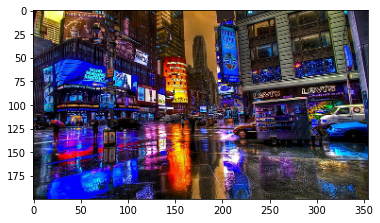

In [7]:
#Читаем картинку
im = cv.imread('/content/manhattan-times-square.png')
    
# размеры изображения
newH = 200  #высота
newW = int(im.shape[1]*200/im.shape[0]) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 
#Выводим 

plt.imshow(im)
plt.show()

Selective Search(селективный поиск)

In [8]:
#Настройка модели
cv.setUseOptimized(True) #режим оптимизации
cv.setNumThreads(6)      #количество потоков

In [9]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape) #число найденых объектов

(5186, 4)


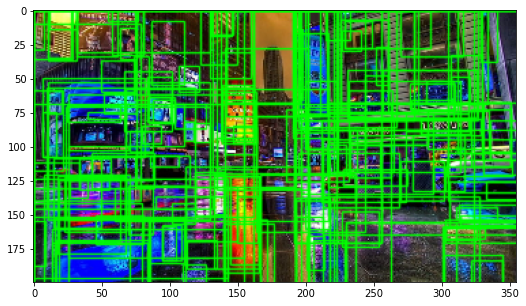

In [10]:
#Построим области

num_Rects = 200 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for i, rect in enumerate(rects): 
    if (i < num_Rects): #пока не больше 
        x, y, w, h = rect    
        cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
    else: 
        break 

# Рисуем на экран
plt.figure(figsize=(16,5))
plt.imshow(im_) 
plt.show()

## **Формирование и обработка результатов детектирования**

In [14]:
# вывод картинки
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

# Загрузка и обработка картинки
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  if display:
    display_image(pil_image)
  return filename

# Отрисовка рамки изображения
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

# Отрисовка всех рамок
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Загрузка детектора

In [17]:
# справа в списке выбора можно поменять архитектуру на SSD или Faster F-CNN
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

Формируем тензор

In [19]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)  # алгоритм кодирования JPEG
  return img

In [22]:
def run_detector(detector, path, max_frames=10):
  img = load_img(path)
  # превращаем изображение из целого в вещественное
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  result = detector(converted_img)
  result = {key:value.numpy() for key,value in result.items()} 
  
  # визуализация.
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_frames)

  display_image(image_with_boxes)
  return result

### Выполняем детектор на 10 объектов

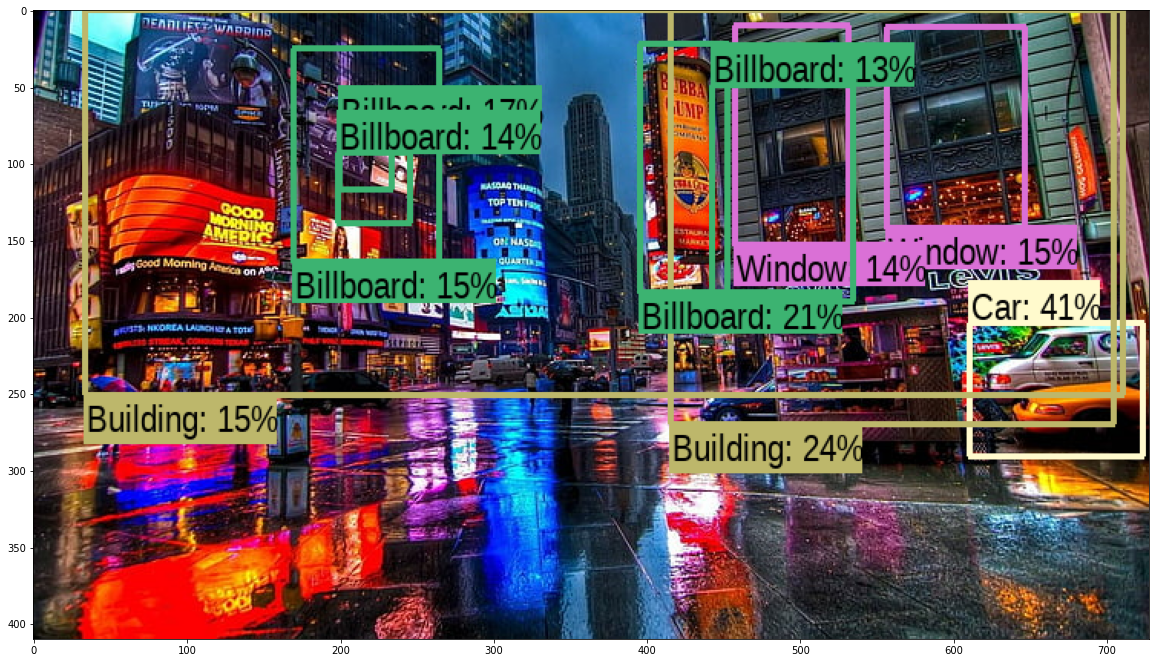

In [23]:
result_10 = run_detector(detector, '/content/manhattan-times-square.png', 10)

### Выполняем детектор на 100 рамок

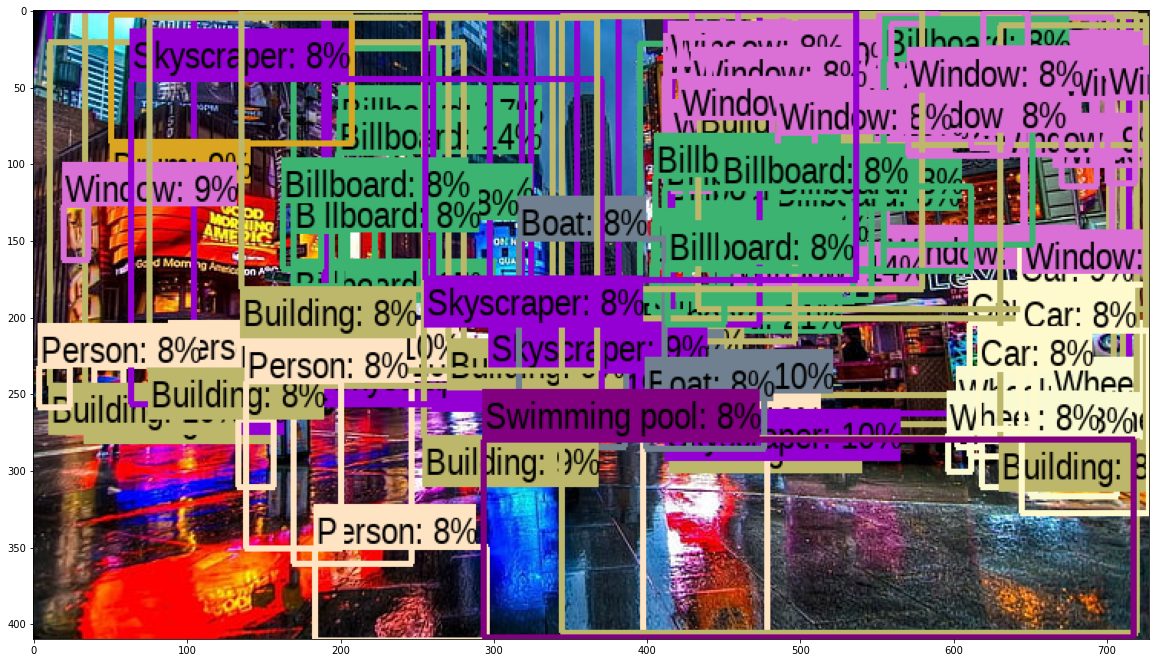

In [24]:
result_100 = run_detector(detector, '/content/manhattan-times-square.png', 100)

Похоже, что у меня получилось применять стандартные модели для детектирования объектов на изображениях. Даже большая часть объектов отнесены к правильным классам. И бассейн на тайм-сквер в нью-йореке в дождливую погоду тоже выглядит правдоподобно. :-)